In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = int(np.sqrt(input_dim))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
class Autoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        # Set hyperparameters
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        # Build the graph
        self.build()

        # Initialize paramters
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        tf.reset_default_graph()        
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z = fc(f3, self.n_z, scope='enc_fc4', activation_fn=tf.nn.relu)

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.recon_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss
        }
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z    

In [4]:
def trainer(model_object, learning_rate=1e-4, 
            batch_size=64, num_epoch=100, n_z=16, log_step=5):
    model = model_object(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
            # Get a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and backward pass 
            # Report computed losses
            losses = model.run_single_step(batch[0])
        end_time = time.time()
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [5]:
# Train a model
model = trainer(Autoencoder)

[Epoch 0] recon_loss: 178.010  (3.642 sec/epoch)
[Epoch 5] recon_loss: 96.228  (3.332 sec/epoch)
[Epoch 10] recon_loss: 87.100  (3.503 sec/epoch)
[Epoch 15] recon_loss: 96.738  (3.552 sec/epoch)
[Epoch 20] recon_loss: 85.417  (3.363 sec/epoch)
[Epoch 25] recon_loss: 89.034  (3.611 sec/epoch)
[Epoch 30] recon_loss: 86.367  (3.346 sec/epoch)
[Epoch 35] recon_loss: 81.093  (3.308 sec/epoch)
[Epoch 40] recon_loss: 82.564  (3.302 sec/epoch)
[Epoch 45] recon_loss: 83.534  (3.309 sec/epoch)
[Epoch 50] recon_loss: 77.956  (3.330 sec/epoch)
[Epoch 55] recon_loss: 72.477  (3.282 sec/epoch)
[Epoch 60] recon_loss: 78.066  (3.325 sec/epoch)
[Epoch 65] recon_loss: 81.519  (3.296 sec/epoch)
[Epoch 70] recon_loss: 74.118  (3.350 sec/epoch)
[Epoch 75] recon_loss: 79.344  (3.310 sec/epoch)
[Epoch 80] recon_loss: 78.419  (3.375 sec/epoch)
[Epoch 85] recon_loss: 69.256  (3.332 sec/epoch)
[Epoch 90] recon_loss: 71.885  (3.279 sec/epoch)
[Epoch 95] recon_loss: 75.397  (3.298 sec/epoch)
Done!


In [6]:
def test_reconstruction(model, mnist, h=28, w=28, batch_size=100):
    # Test the trained model: reconstruction
    batch = mnist.test.next_batch(batch_size)
    x_reconstructed = model.reconstructor(batch[0])

    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 batch[0][i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    plt.figure(figsize=(10, 20))
    plt.imshow(I_reconstructed, cmap='gray')

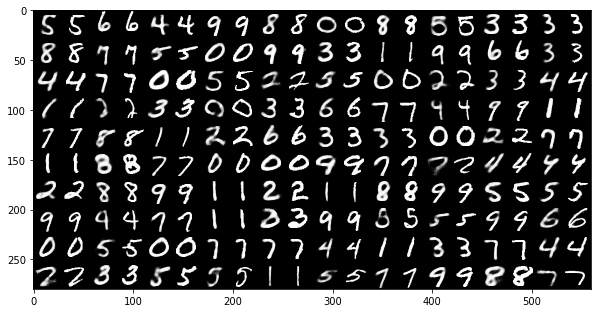

In [7]:
test_reconstruction(model, mnist)

In [8]:
# Train a model with 2d latent space
model_2d = trainer(Autoencoder, n_z=2)

/home/walter/.local/lib/python3.5/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch 0] recon_loss: 179.100  (3.420 sec/epoch)
[Epoch 5] recon_loss: 151.280  (3.310 sec/epoch)
[Epoch 10] recon_loss: 153.090  (3.344 sec/epoch)
[Epoch 15] recon_loss: 149.456  (3.345 sec/epoch)
[Epoch 20] recon_loss: 142.964  (3.332 sec/epoch)
[Epoch 25] recon_loss: 146.143  (3.323 sec/epoch)
[Epoch 30] recon_loss: 141.181  (3.320 sec/epoch)
[Epoch 35] recon_loss: 146.677  (3.312 sec/epoch)
[Epoch 40] recon_loss: 147.063  (3.407 sec/epoch)
[Epoch 45] recon_loss: 143.118  (3.325 sec/epoch)
[Epoch 50] recon_loss: 142.971  (3.257 sec/epoch)
[Epoch 55] recon_loss: 140.664  (3.343 sec/epoch)
[Epoch 60] recon_loss: 133.941  (3.302 sec/epoch)
[Epoch 65] recon_loss: 136.026  (3.362 sec/epoch)
[Epoch 70] recon_loss: 129.401  (3.300 sec/epoch)
[Epoch 75] recon_loss: 137.064  (3.335 sec/epoch)
[Epoch 80] recon_loss: 134.245  (3.418 sec/epoch)
[Epoch 85] recon_loss: 138.634  (3.317 sec/epoch)
[Epoch 90] recon_loss: 135.129  (3.285 sec/epoch)
[Epoch 95] recon_loss: 123.792  (3.239 sec/epoch)
Do

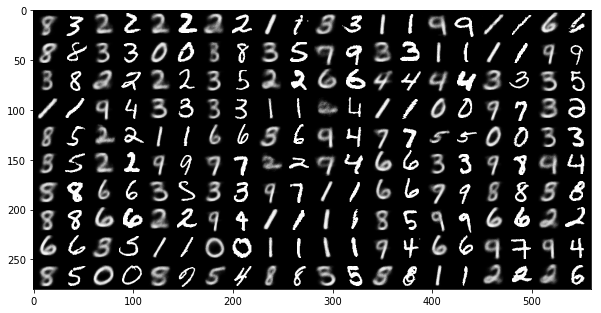

In [9]:
test_reconstruction(model_2d, mnist)

In [10]:
def test_transformation(model_2d, mnist, batch_size=3000):
    # Test the trained model: transformation
    assert model_2d.n_z == 2
    batch = mnist.test.next_batch(batch_size)
    z = model_2d.transformer(batch[0])
    plt.figure(figsize=(10, 8)) 
    plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1), s=20)
    plt.colorbar()
    plt.grid()

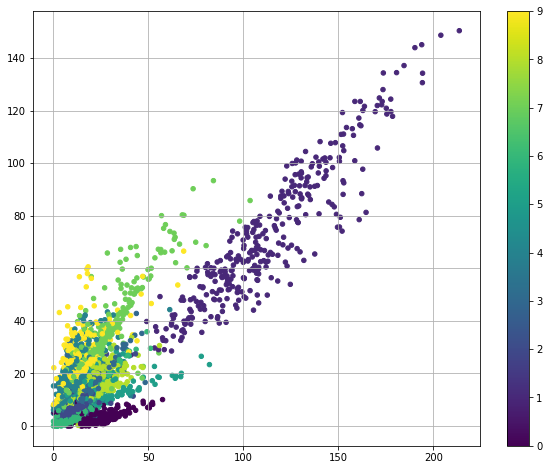

In [11]:
test_transformation(model_2d, mnist)

In [12]:
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        # Set hyperparameters
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        # Build the graph
        self.build()

        # Initialize paramters
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        tf.reset_default_graph()
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [13]:
# Train a vae model
model_vae = trainer(VariantionalAutoencoder)

/home/walter/.local/lib/python3.5/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch 0] recon_loss: 198.251  latent_loss: 4.498  total_loss: 202.749  (4.188 sec/epoch)
[Epoch 5] recon_loss: 120.238  latent_loss: 16.171  total_loss: 136.408  (4.278 sec/epoch)
[Epoch 10] recon_loss: 110.335  latent_loss: 18.738  total_loss: 129.072  (4.184 sec/epoch)
[Epoch 15] recon_loss: 93.949  latent_loss: 19.297  total_loss: 113.247  (4.170 sec/epoch)
[Epoch 20] recon_loss: 95.581  latent_loss: 19.603  total_loss: 115.184  (4.144 sec/epoch)
[Epoch 25] recon_loss: 85.542  latent_loss: 20.101  total_loss: 105.643  (4.181 sec/epoch)
[Epoch 30] recon_loss: 88.537  latent_loss: 20.505  total_loss: 109.042  (4.113 sec/epoch)
[Epoch 35] recon_loss: 93.857  latent_loss: 20.529  total_loss: 114.386  (4.075 sec/epoch)
[Epoch 40] recon_loss: 85.412  latent_loss: 20.973  total_loss: 106.385  (4.158 sec/epoch)
[Epoch 45] recon_loss: 91.740  latent_loss: 20.523  total_loss: 112.264  (4.034 sec/epoch)
[Epoch 50] recon_loss: 84.719  latent_loss: 21.097  total_loss: 105.816  (4.142 sec/epoch)

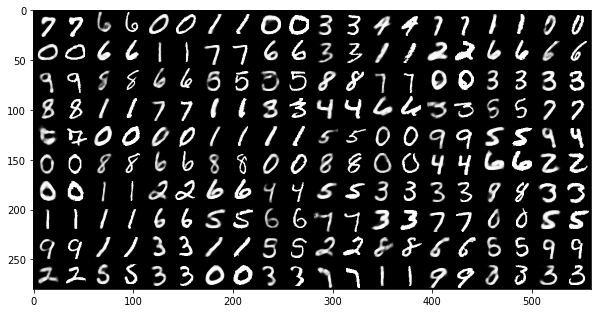

In [14]:
test_reconstruction(model_vae, mnist)

In [15]:
def test_generation(model, z=None, h=28, w=28, batch_size=100):
    # Test the trained model: generation
    # Sample noise vectors from N(0, 1)
    if z is None:
        z = np.random.normal(size=[batch_size, model.n_z])
    x_generated = model.generator(z)    

    n = np.sqrt(batch_size).astype(np.int32)
    I_generated = np.empty((h*n, w*n))
    for i in range(n):
        for j in range(n):
            I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(h, w)
            
    plt.figure(figsize=(8, 8))
    plt.imshow(I_generated, cmap='gray')

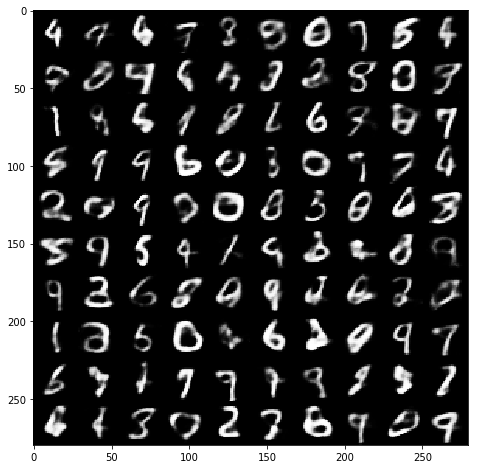

In [16]:
test_generation(model_vae)

In [17]:
# Train a model with 2d latent space
model_vae_2d = trainer(VariantionalAutoencoder, n_z=2)

/home/walter/.local/lib/python3.5/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch 0] recon_loss: 199.993  latent_loss: 3.385  total_loss: 203.378  (4.229 sec/epoch)
[Epoch 5] recon_loss: 164.283  latent_loss: 4.614  total_loss: 168.897  (4.179 sec/epoch)
[Epoch 10] recon_loss: 160.561  latent_loss: 5.186  total_loss: 165.747  (4.188 sec/epoch)
[Epoch 15] recon_loss: 148.866  latent_loss: 5.395  total_loss: 154.261  (4.098 sec/epoch)
[Epoch 20] recon_loss: 147.986  latent_loss: 5.829  total_loss: 153.815  (4.196 sec/epoch)
[Epoch 25] recon_loss: 147.314  latent_loss: 5.836  total_loss: 153.150  (4.107 sec/epoch)
[Epoch 30] recon_loss: 158.520  latent_loss: 5.682  total_loss: 164.202  (4.040 sec/epoch)
[Epoch 35] recon_loss: 141.346  latent_loss: 6.010  total_loss: 147.356  (4.204 sec/epoch)
[Epoch 40] recon_loss: 128.751  latent_loss: 6.142  total_loss: 134.894  (4.191 sec/epoch)
[Epoch 45] recon_loss: 141.799  latent_loss: 6.022  total_loss: 147.821  (4.195 sec/epoch)
[Epoch 50] recon_loss: 155.122  latent_loss: 6.133  total_loss: 161.255  (4.136 sec/epoch)
[

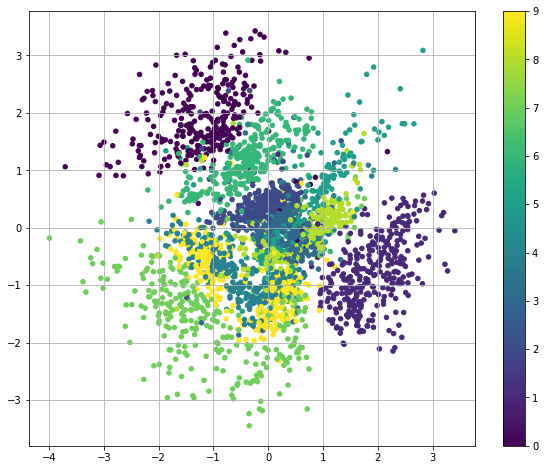

In [18]:
test_transformation(model_vae_2d, mnist)

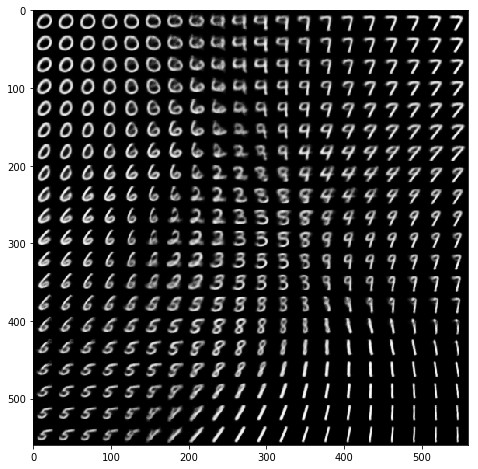

In [19]:
# Test the trained model: uniformly samlpe in the latent space
n = 20
x = np.linspace(-2, 2, n)
y = np.flip(np.linspace(-2, 2, n))
z = []
for i, xi in enumerate(x):
    for j, yi in enumerate(y):
        z.append(np.array([xi, yi]))
z = np.stack(z)

# generate images
test_generation(model_vae_2d, z, batch_size=n**2)